0.884**2 * RBF(length_scale=1.72) + WhiteKernel(noise_level=1.6e-08)
{'1': 0.0, 'x': 0.2989982967317146, 'x^2': 0.008484236546992449}
{'1': 0.0, 'x': 0.842588786573707, 'x^2': 0.008484236546992681, 'x^3': -0.09431026982652871}


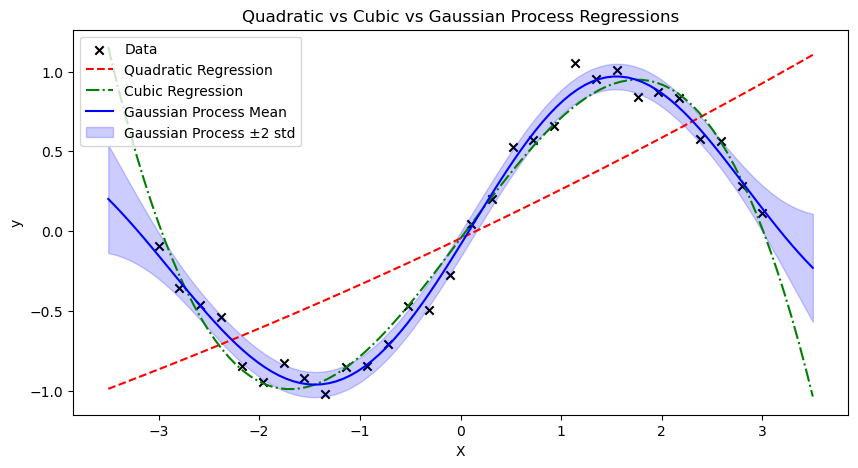

In [11]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# Set a random seed for reproducibility
np.random.seed(42)

# Generate 30 training data points in the range [-3, 3]
X = np.linspace(-3, 3, 30).reshape(-1, 1) # Convert 1D array into a 2D column vector with shape (30,1)

# Generate corresponding target values based on y = sin(x) + noise
y = np.sin(X).ravel() + np.random.normal(0, 0.1, X.shape[0])  # N(0,0.1) is the Gaussian noise
# Note: ".ravel()" flattens the outputs of "np,sin(x)" into a 1D array of shape (30,) to make it compatible with the 1D noise array

# Generate 100 test points for smoother visualization
X_test = np.linspace(-3.5, 3.5, 100).reshape(-1, 1) # Cover a slightly larger range to see behavior at boundaries

# Fit quadratic polynomial regression (Degree = 2)
poly_model = make_pipeline(PolynomialFeatures(2), LinearRegression())
poly_model.fit(X, y)
y_poly_pred = poly_model.predict(X_test) # predictions computed for the test data

# Fit cubic polynomial regression (Degree = 3)
poly_model_cubic = make_pipeline(PolynomialFeatures(3), LinearRegression())
poly_model_cubic.fit(X, y)
y_cubic_pred = poly_model_cubic.predict(X_test)

# Fit GPR with RBF + WhiteKernel functions
kernel = 1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e-1))
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=0.01)
gp_model.fit(X, y) 
# During training, the model optimizes the kernel hyperparameters (eg., length scale and noise level) to best fit the data

# Make predictions using GPR
y_gp_pred, y_gp_std = gp_model.predict(X_test, return_std=True)

# Check the learned noise level
print(gp_model.kernel_)

# Check the coefficients of each term in the quadratic regression
linear_regressor_quad = poly_model.named_steps['linearregression']
poly_features_quad = poly_model.named_steps['polynomialfeatures']
feature_names_quad = poly_features_quad.get_feature_names_out(["x"])
coefficients_quad = linear_regressor_quad.coef_
coeff_dict_quad = dict(zip(feature_names_quad, coefficients_quad))
print(coeff_dict_quad)

# Check the coefficients of each term in the cubic regression
linear_regressor_cubic = poly_model_cubic.named_steps['linearregression']
poly_features_cubic = poly_model_cubic.named_steps['polynomialfeatures']
feature_names_cubic = poly_features_cubic.get_feature_names_out(["x"])
coefficients_cubic = linear_regressor_cubic.coef_
coeff_dict_cubic = dict(zip(feature_names_cubic, coefficients_cubic))
print(coeff_dict_cubic)

# Visualization
plt.figure(figsize=(10, 5))

# Scatter plot of the original data
plt.scatter(X, y, color='black', label="Data", marker='x')

# Plot quadratic regression predictions
plt.plot(X_test, y_poly_pred, label="Quadratic Regression", linestyle="dashed", color="red")

# Plot cubic regression predictions
plt.plot(X_test, y_cubic_pred, label="Cubic Regression", linestyle="dashdot", color="green")

# Plot GP Predictions (mean and uncertainty band)
plt.plot(X_test, y_gp_pred, label="Gaussian Process Mean", color="blue")
plt.fill_between(X_test.ravel(), y_gp_pred - 2*y_gp_std, y_gp_pred + 2*y_gp_std, 
                 color="blue", alpha=0.2, label="Gaussian Process ±2 std")

# Add labels, title, and legend
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.title("Quadratic vs Cubic vs Gaussian Process Regressions")

# Show the plot
plt.show()